# # HyperLLM Benchmark & Usage Example Notebook
#
# This notebook demonstrates the core functionality of HyperLLM:
#
# - **Generating test prompts** with varying complexity.
# - **Processing prompts concurrently** with error simulation, caching, and retry logic.
# - **Live metrics visualization** showing items processed over time and the API success/error rate.
# - **Comparing different concurrency configurations** to see how performance scales.
#
# Let’s get started!

## 1. Library Setup & Configuration

In [1]:
import os
import time
import random
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from IPython.display import clear_output, display
from IPython.display import clear_output, display

# Import HyperLLM components.
from multi_processing.llm_client import DeepSeekClient
from multi_processing.processor import LLMProcessor
from multi_processing.processor_config import ProcessorConfig

In [4]:
# Initialize client with API key from environment
client = DeepSeekClient(api_key="sk-cd405682db094b6781f9f815840163d8")

# Configure processor with high-performance settings
config = ProcessorConfig(
    max_workers=500,
    enable_dynamic_token_batching=True,
    cache_enabled=False,
    dynamic_rate_limit=False,
    metrics_output_path='eval_metrics.json'
)

# Create the processor instance
processor = LLMProcessor(client, config)


## 2. Define Utility Functions


In [3]:
# We now define a few helper functions:
#
# - **`generate_test_prompts`** creates a list of test prompts with varying lengths.
# - **`process_wrapper`** wraps the API call and simulates a 2% error rate.
# - **`run_benchmark`** processes a batch of prompts while updating live plots of throughput and success rates.
# - **`compare_concurrency_levels`** runs short benchmarks using different numbers of workers.
# - **`generate_report`** plots the benchmark results.

def generate_test_prompts(num_prompts=1000):
    """Generate realistic test prompts with varying complexity."""
    base_prompt = "Analyze this text for sentiment and key themes: {text}"
    texts = [
        f"Customer review: {'Excellent ' * i}product!" if i % 2 == 0 
        else f"Technical paper: {'AI safety ' * i}considerations"
        for i in range(1, num_prompts + 1)
    ]
    return [base_prompt.format(text=t) for t in texts]

def process_wrapper(prompt):
    """Processing function """
   
    # Use the processor's retry-enabled processing (using a private method here for demonstration)
    return processor.process_batch(
        prompt,
        lambda p: client.call_api(p, system_prompt="You are a helpful AI assistant")
    )

def run_benchmark(prompts, update_interval=50):
    """
    Process prompts and update live plots of:
      - Items processed vs. time.
      - API success vs. error counts.
    """
    results = []
    throughput = []
    start_time = time.time()
    
    # Process prompts using HyperLLM's concurrency engine.
    for i, result in enumerate(processor.process_batch(prompts, process_wrapper)):
        results.append(result)
        
        # Every `update_interval` items, record and update the live plot.
        if (i + 1) % update_interval == 0 or (i + 1) == len(prompts):
            elapsed = time.time() - start_time
            throughput.append({
                'time': elapsed,
                'items': i + 1,
                'tokens': processor.metrics['token_usage']['total_tokens']
            })
            
            # Clear previous output and update the plots.
            clear_output(wait=True)
            fig, axs = plt.subplots(1, 2, figsize=(12, 4))
            
            # Plot: Items Processed vs Time
            times = [t['time'] for t in throughput]
            items_processed = [t['items'] for t in throughput]
            axs[0].plot(times, items_processed, marker='o', color='blue')
            axs[0].set_title('Items Processed vs Time')
            axs[0].set_xlabel('Time (seconds)')
            axs[0].set_ylabel('Items Processed')
            
            # Plot: API Call Success vs Errors
            success = processor.metrics['api_calls'].get('successful', 0)
            errors = processor.metrics['api_calls'].get('failed', 0)
            axs[1].bar(['Success', 'Errors'], [success, errors], color=['green', 'red'])
            axs[1].set_title('API Call Success vs Errors')
            
            plt.tight_layout()
            display(fig)
            plt.close(fig)
    
    # Final clear to remove the intermediate plots.
    clear_output(wait=True)
    return results, throughput

## 4. Comparative Analysis

In [4]:
def compare_concurrency_levels():
    """
    Run a short benchmark for different max_workers settings and collect:
      - Total duration.
      - Items processed per second.
      - Tokens processed per second.
    """
    workers_range = [4, 8, 16, 32]
    benchmarks = {}
    
    for workers in workers_range:
        config.max_workers = workers  # Update the configuration
        # Create a new processor instance to reset metrics for each run.
        proc = LLMProcessor(client, config)
        prompts = generate_test_prompts(500)
        start_time = time.time()
        proc.process_batch(prompts, process_wrapper)
        duration = time.time() - start_time
        
        benchmarks[workers] = {
            'duration': duration,
            'throughput': 500 / duration,
            'token_throughput': proc.metrics['token_usage']['total_tokens'] / duration
        }
    
    return benchmarks

## 5. Visualization & Reporting

In [5]:
def generate_report(benchmarks):
    """Generate visual reports from the benchmark data."""
    df = pd.DataFrame.from_dict(benchmarks, orient='index')
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    df['throughput'].plot.bar(ax=axs[0], color='skyblue')
    axs[0].set_title('Items per Second by Concurrency Level')
    axs[0].set_xlabel('Max Workers')
    axs[0].set_ylabel('Items/sec')
    
    df['token_throughput'].plot.bar(ax=axs[1], color='salmon')
    axs[1].set_title('Tokens per Second by Concurrency Level')
    axs[1].set_xlabel('Max Workers')
    axs[1].set_ylabel('Tokens/sec')
    
    plt.tight_layout()
    plt.show()
    
    return df.style.background_gradient(cmap='viridis')

## Main Execution

In [6]:

test_prompts = generate_test_prompts(1000)

# Run the benchmark and update live plots
results, throughput = run_benchmark(test_prompts, update_interval=50)

# Compare different concurrency settings
benchmarks = compare_concurrency_levels()

# Generate and display the final report
report = generate_report(benchmarks)
display(report)

Processing items:  99%|█████████▉| 542/545 [10:01<00:03,  1.11s/it] 


KeyboardInterrupt: 

In [7]:
# 2) Define a processing function that calls the LLM.
def process_fn(prompt):
    """
    Call the LLM API with a given prompt.
    The system prompt instructs the LLM to be a helpful assistant.
    """
    response = client.call_api(prompt=prompt, system_prompt="You are a helpful AI assistant.")
    return response

def generate_synthetic_prompts(n):
    """Generate synthetic prompts for LLM to create customer reviews."""
    prompts = []
    for i in range(n):
        if i % 2 == 0:
            prompt = f"Generate a synthetic positive customer review for product {i}."
        else:
            prompt = f"Generate a synthetic negative customer review for product {i}."
        prompts.append(prompt)
    return prompts

# Generate 1000 synthetic prompts
prompts = generate_synthetic_prompts(1000)

In [8]:
prompts

['Generate a synthetic positive customer review for product 0.',
 'Generate a synthetic negative customer review for product 1.',
 'Generate a synthetic positive customer review for product 2.',
 'Generate a synthetic negative customer review for product 3.',
 'Generate a synthetic positive customer review for product 4.',
 'Generate a synthetic negative customer review for product 5.',
 'Generate a synthetic positive customer review for product 6.',
 'Generate a synthetic negative customer review for product 7.',
 'Generate a synthetic positive customer review for product 8.',
 'Generate a synthetic negative customer review for product 9.',
 'Generate a synthetic positive customer review for product 10.',
 'Generate a synthetic negative customer review for product 11.',
 'Generate a synthetic positive customer review for product 12.',
 'Generate a synthetic negative customer review for product 13.',
 'Generate a synthetic positive customer review for product 14.',
 'Generate a synthet

In [11]:
# Configure processor with static (hardset) batching settings
config_static = ProcessorConfig(
    max_workers=100,           # High concurrency
    enable_batch_prompts=True,
    batch_size = 10
  
)
processor_static = LLMProcessor(llm_client=client, config=config_static)

In [12]:
def run_test(processor, prompts, label="Test"):
    """
    Run processor.process_batch on a list of prompts and report key metrics.
    """
    print(f"\nRunning {label} on {len(prompts)} prompts...")
    start = time.time()
    # The desc parameter updates the progress bar with our label.
    results = processor.process_batch(prompts, process_fn, cache_prefix=label, desc=label)
    duration = time.time() - start
    tokens = processor.metrics.get("token_usage", {}).get("total_tokens", 0)
    throughput = len(prompts) / duration if duration > 0 else 0
    print(f"{label} completed in {duration:.2f} seconds.")
    print(f"Tokens processed: {tokens}.")
    print(f"Throughput: {throughput:.2f} items/sec.")
    return results, duration, tokens

# Run the static batching test
results_static, duration_static, tokens_static = run_test(processor_static, prompts, label="Static Batching")


Running Static Batching on 1000 prompts...


Static Batching: 100%|██████████| 1000/1000 [07:24<00:00,  2.25it/s]

Static Batching completed in 444.37 seconds.
Tokens processed: 150979.
Throughput: 2.25 items/sec.


In [21]:
tokens_static

28432

In [22]:
import os
import time
import random
import string
import json
from typing import Dict, Any, List
import concurrent.futures
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

from multi_processing.llm_client import DeepSeekClient

# Set your real API key here or via the environment.
API_KEY = "sk-cd405682db094b6781f9f815840163d8"

########################################
# 2) Generate a Synthetic Dataset of Review Prompts
########################################
def generate_reviews(num_items: int = 100) -> List[Dict[str, Any]]:
    """
    Generate a dataset of product reviews using the LLM.
    Each prompt instructs the LLM to generate a review in valid JSON format:
      {"id": <id>, "product": <product>, "sentiment": <sentiment>, "review": <review>}
    """
    prompts = []
    for i in range(num_items):
        prompt = (
            f"Generate a product review in valid JSON format. "
            f"Return an object with keys: id, product, sentiment, review. "
            f"Ensure the 'id' field equals {i}. "
            "The review should be 2-3 sentences long, natural, and specific."
        )
        prompts.append({
            "id": i,
            "text": prompt
        })
    # Use item-level processing for generation.
    config = ProcessorConfig(
        cache_enabled=False,
        max_workers=20,
        rate_limit=0.0,
        max_retries=1,
        batch_size=1,            # one prompt per call
        fail_fast=False,
        enable_batch_prompts=False
    )
    client = DeepSeekClient(api_key=API_KEY, model="deepseek-chat", temperature=0.7)
    processor = LLMProcessor(llm_client=client, config=config)
    
    results = processor.process_batch(
        items=prompts,
        process_fn=lambda item: client.call_api(
            prompt=item["text"],
            system_prompt="You are a customer writing product reviews. Write naturally and return valid JSON."
        ),
        cache_prefix="gen",
        use_cache=False
    )
    
    dataset = []
    for prompt_item, result in zip(prompts, results):
        try:
            parsed = json.loads(result.get("content", ""))
            # Ensure the returned id matches.
            if parsed.get("id") != prompt_item["id"]:
                parsed["id"] = prompt_item["id"]
            dataset.append(parsed)
        except Exception as e:
            dataset.append({
                "id": prompt_item["id"],
                "error": f"Parsing failed: {str(e)}",
                "raw": result.get("content", "")
            })
    return dataset

########################################
# 3) Phase 2 – Classification of Sentiment
########################################

def classify_sentiment(item: Dict[str, Any], client: DeepSeekClient) -> Dict[str, Any]:
    """
    Classify the sentiment of a review.
    Input: item with key "review" (generated in Phase 1).
    Output: JSON object with key "classified_sentiment".
    """
    review_text = item.get("review", "")
    if not review_text:
        return {"id": item.get("id"), "error": "No review text."}
    prompt = (
        f"Classify the sentiment of the following product review. "
        f"Return a JSON object with the key 'classified_sentiment' whose value is one of: positive, negative, neutral.\n\n"
        f"Review: {review_text}"
    )
    response = client.call_api(
        prompt=prompt,
        system_prompt="You are an expert reviewer. Return valid JSON."
    )
    try:
        parsed = json.loads(response.get("content", ""))
    except Exception as e:
        parsed = {"error": f"Parsing failed: {str(e)}", "raw": response.get("content", "")}
    return {"id": item.get("id"), "classified_sentiment": parsed.get("classified_sentiment", "unknown")}

def create_classification_subbatch_prompt(items: List[Dict[str, Any]]) -> str:
    """
    Create a prompt for classifying sentiment for a sub-batch of reviews.
    Instruct the LLM to return a JSON array of objects with keys: id, classified_sentiment.
    """
    combined_text = ""
    for itm in items:
        combined_text += f"(ID={itm['id']}) Review: {itm.get('review', '')}\n"
    prompt = (
        f"Classify the sentiment for the following {len(items)} product reviews. "
        "For each review, return a JSON object with keys: id, classified_sentiment, "
        "where classified_sentiment is one of: positive, negative, neutral. "
        "Return the results as a JSON array.\n" + combined_text
    )
    return prompt

def classify_sentiment_subbatch(items: List[Dict[str, Any]], client: DeepSeekClient) -> Dict[int, Any]:
    """
    Process a sub-batch of reviews: call the LLM once.
    Use a response parser that expects a JSON array of objects.
    """
    prompt = create_classification_subbatch_prompt(items)
    response = client.call_api(
        prompt=prompt,
        system_prompt="You are an expert reviewer. Return valid JSON."
    )
    result_map = {}
    try:
        parsed = json.loads(response.get("content", ""))
        if isinstance(parsed, list):
            for obj in parsed:
                if "id" in obj:
                    result_map[obj["id"]] = obj
        else:
            # Fallback: assign an error for all.
            for itm in items:
                result_map[itm["id"]] = {"error": "Expected JSON array", "raw": response.get("content", "")}
    except Exception as e:
        for itm in items:
            result_map[itm["id"]] = {"error": f"Parsing failed: {str(e)}", "raw": response.get("content", "")}
    return result_map

########################################
# 4) Experimental Modes for Classification
########################################

# (A) Sequential (Control)
def run_sequential_classification(dataset: List[Dict[str, Any]], client: DeepSeekClient):
    results = []
    start_time = time.perf_counter()
    for item in tqdm(dataset, desc="Sequential Classification"):
        res = classify_sentiment(item, client)
        results.append(res)
    elapsed = time.perf_counter() - start_time
    print(f"[Sequential Classification] Processed {len(results)} items in {elapsed:.2f} seconds.")
    return results, elapsed

# (B) Library Item-Level Concurrency
def run_library_item_level_classification(dataset: List[Dict[str, Any]], max_workers: int = 10):
    config = ProcessorConfig(
        cache_enabled=False,
        max_workers=max_workers,
        rate_limit=0.0,
        max_retries=1,
        batch_size=1,            # one item per call
        fail_fast=False,
        enable_batch_prompts=False
    )
    client = DeepSeekClient(api_key=API_KEY, model="deepseek-chat", temperature=0.1)
    processor = LLMProcessor(llm_client=client, config=config)
    
    def process_fn(item):
        return classify_sentiment(item, client)
    
    start_time = time.perf_counter()
    results = processor.process_batch(
        items=dataset,
        process_fn=process_fn,
        cache_prefix="classify_item",
        use_cache=False
    )
    elapsed = time.perf_counter() - start_time
    print(f"[Library Item-Level Classification] Processed {len(results)} items in {elapsed:.2f} seconds.")
    return results, elapsed, processor.metrics

# (C) Library Batch-Mode Concurrency
def run_library_batch_mode_classification(dataset: List[Dict[str, Any]], max_workers: int = 10, batch_size: int = 5):
    config = ProcessorConfig(
        cache_enabled=False,
        max_workers=max_workers,
        rate_limit=0.0,
        max_retries=1,
        batch_size=batch_size,  # sub-batch size
        fail_fast=False,
        enable_batch_prompts=True
    )
    client = DeepSeekClient(api_key=API_KEY, model="deepseek-chat", temperature=0.1)
    processor = LLMProcessor(llm_client=client, config=config)
    
    def process_fn(subbatch: List[Dict[str, Any]]) -> Dict[int, Any]:
        return classify_sentiment_subbatch(subbatch, client)
    
    start_time = time.perf_counter()
    dict_list = processor.process_batch(
        items=dataset,
        process_fn=process_fn,
        cache_prefix="classify_batch",
        use_cache=False,
        desc="Library Batch Classification"
    )
    elapsed = time.perf_counter() - start_time
    combined = {}
    for subdict in dict_list:
        combined.update(subdict)
    print(f"[Library Batch Classification] Processed {len(combined)} items in {elapsed:.2f} seconds (sub-batch size={batch_size}).")
    return combined, elapsed, processor.metrics

# (D) Raw Concurrency (ThreadPool)
def run_raw_classification(dataset: List[Dict[str, Any]], max_workers: int = 10):
    client = DeepSeekClient(api_key=API_KEY, model="deepseek-chat", temperature=0.1)
    results = []
    start_time = time.perf_counter()
    with tqdm(total=len(dataset), desc="Raw Classification") as pbar:
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(classify_sentiment, item, client) for item in dataset]
            for future in concurrent.futures.as_completed(futures):
                results.append(future.result())
                pbar.update(1)
    elapsed = time.perf_counter() - start_time
    print(f"[Raw Classification] Processed {len(results)} items in {elapsed:.2f} seconds.")
    return results, elapsed

########################################
# 5) Graphing and Reporting Functions
########################################

def plot_performance(results: Dict[str, Dict[str, float]]):
    modes = list(results.keys())
    throughputs = [results[mode]['throughput'] for mode in modes]
    elapsed_times = [results[mode]['elapsed'] for mode in modes]
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].bar(modes, throughputs, color='skyblue')
    axs[0].set_title('Throughput (Items per Second)')
    axs[0].set_ylabel('Items/sec')
    
    axs[1].bar(modes, elapsed_times, color='salmon')
    axs[1].set_title('Elapsed Time (Seconds)')
    axs[1].set_ylabel('Seconds')
    
    plt.tight_layout()
    plt.show()



In [23]:
# --- Phase 1: Generate the Reviews Dataset ---
print("Generating reviews dataset...")
review_dataset = generate_reviews(num_items=50)  # Use a small number for testing.
# Filter out any generation failures.
review_dataset = [item for item in review_dataset if "error" not in item]
print(f"Generated {len(review_dataset)} reviews.")


Generating reviews dataset...


Processing items: 100%|██████████| 50/50 [02:09<00:00,  2.60s/it]

Generated 0 reviews.


In [27]:
review_dataset

IndexError: list index out of range

In [ ]:
d

Processing items:   0%|          | 0/100 [00:00<?, ?it/s]

Processing items: 100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


[Library Item-Level] Processed 100 items in 64.85 seconds.


Processing items: 100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


[Library Item-Level] Processed 100 items in 125.35 seconds.


Library Batch Mode: 100%|██████████| 20/20 [01:16<00:00,  3.80s/it]


[Library Batch Mode] Processed 100 items in 76.07 seconds (sub-batch size=5).


Raw Concurrency: 100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


[Raw Concurrency] Processed 100 items in 121.23 seconds.

Performance Summary:
Sequential: {'elapsed': 64.84594608400948, 'throughput': 1.5421164473481133}
Library Item-Level: {'elapsed': 125.35277158301324, 'throughput': 0.7977486156640446, 'tokens_sec': 0.0}
Library Batch Mode: {'elapsed': 76.07191175001208, 'throughput': 1.3145456410852476, 'tokens_sec': 0.0}
Raw Concurrency: {'elapsed': 121.22950029105414, 'throughput': 0.8248817306011719}


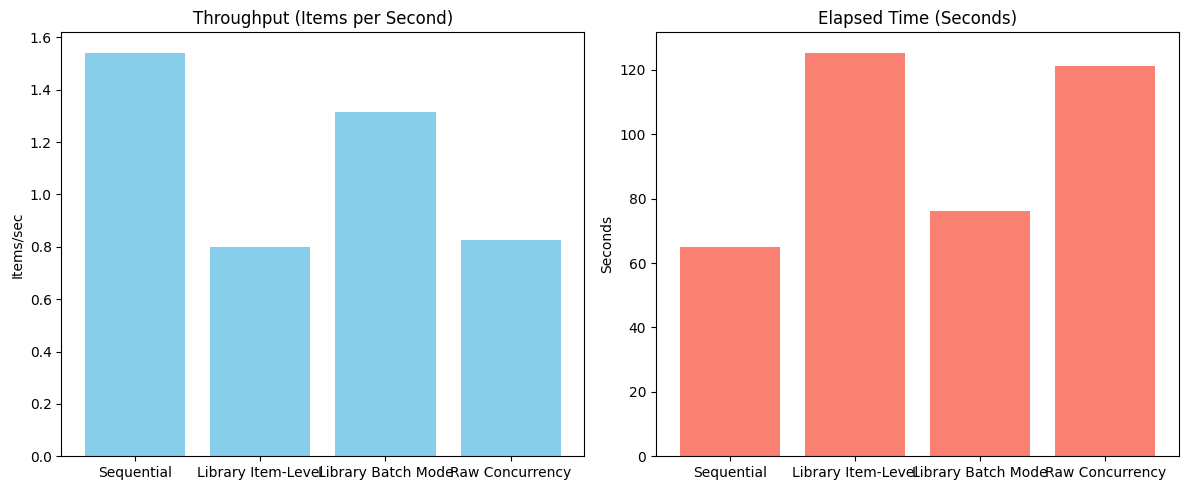

In [18]:

# --- Phase 2: Classification Experiments ---
print("Running classification experiments...")

control_client = DeepSeekClient(api_key=API_KEY, model="deepseek-chat", temperature=0.1)
seq_results, seq_elapsed, seq_metrics = run_library_item_level_classification(review_dataset, max_workers=10)

lib_item_results, lib_item_elapsed, item_metrics = run_library_item_level_classification(review_dataset, max_workers=100)

lib_batch_results, lib_batch_elapsed, batch_metrics = run_library_batch_mode_classification(review_dataset, max_workers=100, batch_size=5)

raw_results, raw_elapsed = run_raw_classification(review_dataset, max_workers=100)

performance = {
    "Sequential": {
        "elapsed": seq_elapsed,
        "throughput": len(review_dataset) / seq_elapsed
    },
    "Library Item-Level": {
        "elapsed": lib_item_elapsed,
        "throughput": len(review_dataset) / lib_item_elapsed,
        "tokens_sec": item_metrics.get("token_usage", {}).get("total_tokens", 0) / lib_item_elapsed
    },
    "Library Batch Mode": {
        "elapsed": lib_batch_elapsed,
        "throughput": len(review_dataset) / lib_batch_elapsed,
        "tokens_sec": batch_metrics.get("token_usage", {}).get("total_tokens", 0) / lib_batch_elapsed
    },
    "Raw Concurrency": {
        "elapsed": raw_elapsed,
        "throughput": len(review_dataset) / raw_elapsed
    }
}

print("\nPerformance Summary:")
for mode, metrics in performance.items():
    print(f"{mode}: {metrics}")

plot_performance(performance)


In [19]:
dataset

[{'id': 0,
  'text': 'Generate a product review in JSON format. Return an object with the keys: id, product, sentiment, review. The review should be 2-3 sentences long, natural, and specific.'},
 {'id': 1,
  'text': 'Generate a product review in JSON format. Return an object with the keys: id, product, sentiment, review. The review should be 2-3 sentences long, natural, and specific.'},
 {'id': 2,
  'text': 'Generate a product review in JSON format. Return an object with the keys: id, product, sentiment, review. The review should be 2-3 sentences long, natural, and specific.'},
 {'id': 3,
  'text': 'Generate a product review in JSON format. Return an object with the keys: id, product, sentiment, review. The review should be 2-3 sentences long, natural, and specific.'},
 {'id': 4,
  'text': 'Generate a product review in JSON format. Return an object with the keys: id, product, sentiment, review. The review should be 2-3 sentences long, natural, and specific.'},
 {'id': 5,
  'text': 'Gen

In [20]:
control_results

[{'id': 22,
  'input': 'Generate a product review in JSON format. Return an object with the keys: id, product, sentiment, review. The review should be 2-3 sentences long, natural, and specific.',
  'output': {'error': 'Invalid JSON'},
  'success': True},
 {'id': 12,
  'input': 'Generate a product review in JSON format. Return an object with the keys: id, product, sentiment, review. The review should be 2-3 sentences long, natural, and specific.',
  'output': {'error': 'Invalid JSON'},
  'success': True},
 {'id': 29,
  'input': 'Generate a product review in JSON format. Return an object with the keys: id, product, sentiment, review. The review should be 2-3 sentences long, natural, and specific.',
  'output': {'error': 'Invalid JSON'},
  'success': True},
 {'id': 14,
  'input': 'Generate a product review in JSON format. Return an object with the keys: id, product, sentiment, review. The review should be 2-3 sentences long, natural, and specific.',
  'output': {'error': 'Invalid JSON'},
